# Análise de um grupo Bolsonarista no WhatsApp

Após alguns surpreendentes resultados no primeiro turno da eleição de 2018, resolvi acompanhar um grupo de WhatsApp da campanha do candidato Jair Bolsonaro. Tinha curiosidade entender como funcionava tão importante engrenagem da campanha.

A quantidade de mensagens é enorme. Não dá para ler tudo. Resolvi então fazer análise de dados para compreender padrões seu funcionamento.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from dateutil.parser import parse as dtparse
%matplotlib inline

from IPython.core.display import display, HTML
def printBig(s):
    display(HTML('<span style="font-size:2em;color:darkblue">{:s}</span>'.format(s)))
    

In [2]:
plt.rcParams['figure.figsize'] = [14, 7]
plt.rc('axes', titlesize=20)

## Reportagens sobre a campanha no WhatsApp

Algumas reportagens sobre o esquema de divulgação:
- [El País - A máquina de ‘fake news’ nos grupos a favor de Bolsonaro no WhatsApp](https://brasil.elpais.com/brasil/2018/09/26/politica/1537997311_859341.html)
- [Folha - Estudo aponta para automação no envio de mensagens e orquestração entre grupos de WhatsApp pró-Bolsonaro](https://www1.folha.uol.com.br/poder/2018/10/estudo-aponta-para-automacao-no-envio-de-mensagens-e-orquestracao-entre-grupos-de-whatsapp-pro-bolsonaro.shtml)
- [Folha - Grupos de WhatsApp simulam organização militar e compartilham apoio a Bolsonaro](https://www1.folha.uol.com.br/poder/2018/10/grupos-de-whatsapp-simulam-organizacao-militar-e-compartilham-apoio-a-bolsonaro.shtml)
- [BBC - How WhatsApp is being abused in Brazil's elections](https://www.bbc.com/news/technology-45956557)
- [New York Times - Disinformation Spreads on WhatsApp Ahead of Brazilian Election](https://www.nytimes.com/2018/10/19/technology/whatsapp-brazil-presidential-election.html)

## Mas as postagens são mentiras?

**Sim.**

Não vou abordar isto aqui, porque basta acompanhar um pouco os grupos para perceber que **não há a mínima preocupação com a verdade**. O El Pais publicou uma [boa coleção de mentiras](https://brasil.elpais.com/especiais/2018/eleicoes-brasil/conversacoes-whatsapp/) nos grupos Bolsonaristas.

Você pode ter mais trabalho para chegar à mesma conclusão, como fez a [Agência](https://piaui.folha.uol.com.br/lupa/2018/10/17/whatsapp-lupa-usp-ufmg-imagens/) [Lupa](https://piaui.folha.uol.com.br/lupa/2018/10/18/imagens-falsas-whatsapp-presidenciaveis-lupa-ufmg-usp/) e os [pesquisadores da UFMG](https://www.eleicoes-sem-fake.dcc.ufmg.br/), para mim basta ver que boa parte das notícias são de imagens como estas:

- Jogo do Bicho fazendo propaganda para Haddad.
- Propaganda Haddad para presidários.

<img alt="Jogo do Bicho fazendo propaganda para Haddad" src="jogo-do-bicho-haddad.jpg" width="29.465%" style="float:left;" align="top"><img alt="Propaganda para presidiários" src="panfleto-presidiarios.jpg" width="70%" style="float:right;" align="top">




Carregando as mensagens para analisá-las.

In [3]:
#Parse de arquivo para dataframe
#whatsAppExported = 'https://drive.google.com/file/d/1tXBKAsAEy_wPI8h8xvsyXy-vJB0_J78c/view?usp=sharing'
whatsAppExported = "conversas/Conversa do WhatsApp com BOLSONARO, o Mito ! 😎👉👉.txt"

# exportar arquivo Abrindo grupo → configurações → mais → exportar conversa
# um parse ingênuo

import urllib.request
import re
import pandas as pd

inicioRE = re.compile(r'^(\d\d/\d\d/\d{4} \d\d:\d\d) - (.*)')
dadosRE = re.compile('^\u200e?\u202a(?P<fone>.*)\u202c'  + r'(?P<tipo>.) *(?P<texto>.*)')
foneRE = re.compile('[^0-9]+')
with open(whatsAppExported, encoding='utf8') as f:
    dados = []
    msg = []
    obs = {} # uma única observação
    txt = []
    for line in f:
        m = inicioRE.match(line)
        if m:
            if obs:
                obs['texto'] = '\n'.join(txt)
                dados.append(obs)
                obs = {}
                txt = []

            obs['data'] = pd.to_datetime(m.group(1), dayfirst=True) #brasil
            line = m.group(2)
            m = dadosRE.match(line)
            if m:
                grupos = m.groupdict()
                obs.update(grupos)

                obs['pais'], obs['uf'], obs['tel'] = foneRE.split(grupos['fone'][1:], #tirando o +
                                                                  maxsplit=2)
                txt = [obs['texto']]
            else:
                txt.append(line)
        else:
            txt.append(line)
        date = line[:16]
        
df = pd.DataFrame(dados)


Vou obfuscar os números de telefone para não invadir a privacidade de ninguém. Os últimos dígitos serão trocados.

In [4]:
#obfuscando os telefones para na hora de mostrar na tela não violar a privacidade de ninguém
fones_originais = df[['fone', 'tel']].drop_duplicates()
num_fones_originais = len(fones_originais)
#fones_originais['fone_obfuscado'] = fones_originais.fone.str[:-4] + fones_originais.index.format(formatter='{:>04d}'.format)
#fones_originais['tel_obfuscado'] = fones_originais.tel.str[:-4] + fones_originais.index.format(formatter='{:>04d}'.format)
fones_originais['obfuscado'] = fones_originais.index.format(formatter='{:>04d}'.format)
fones_originais['fone_obfuscado'] = fones_originais.fone.str[:-5] + '#' + fones_originais.obfuscado
fones_originais['tel_obfuscado'] =  fones_originais.tel.str[:-5]  + '#' + fones_originais.obfuscado
assert len(fones_originais.fone_obfuscado.unique()) == num_fones_originais, "Perdi informação, impossível"

df_joined = df.merge(fones_originais, on='fone', how='left')
df['fone'] = df_joined.fone_obfuscado
df['tel'] = df_joined.tel_obfuscado
%xdel df_joined
df.head()


,data,fone,pais,tel,texto,tipo,uf
0,2018-10-15 12:22:00,NaN,NaN,NaN,As mensagens enviadas a este grupo estão agora...,NaN,NaN
1,2018-10-11 18:58:00,+55 11 98597#0001,55,98597#0001,"criou o grupo ""BOLSONARO, o Mito ! 😎👉👉""",,11
2,2018-10-15 12:21:00,NaN,NaN,NaN,Você entrou usando o link de convite deste grupo,NaN,NaN
3,2018-10-15 12:30:00,+55 31 8768#0003,55,8768#0003,<Arquivo de mídia oculto>,:,31
4,2018-10-15 12:30:00,+55 31 8768#0003,55,8768#0003,com a palavra o porco marxista,:,31


In [5]:
# Categorizando as mensagens atribuindo um tipo para cada.
df.loc[(df.tipo==':') & (df.texto.str.contains('<Arquivo de mídia oculto>') ), 'tipo'] = 'midia'
df.loc[(df.tipo==':') & (df.texto.str.contains('Acesse este link para entrar no meu grupo do WhatsApp')), 'tipo'] = 'convite'
df.loc[(df.tipo==':') & (df.texto.str.contains('youtu.?be')), 'tipo'] = 'youtube'
df.loc[(df.tipo==':') & (df.texto.str.contains('https://www.facebook.com', case=False)), 'tipo'] = 'facebook'
df.loc[(df.tipo==':') & (df.texto.str.contains('https?://', case=False)), 'tipo'] = 'link'
df.loc[(df.tipo==':') & (df.texto.str.contains('Esta mensagem foi apagada')), 'tipo'] = 'apagada'
df.loc[(df.texto.str.contains('^removeu')), 'tipo'] = 'banimento'
df.loc[(df.texto.str.contains('^entrou usando o')), 'tipo'] = 'assinatura'
df.loc[(df.texto.str.contains('saiu$', case=False)), 'tipo'] = 'desistencia'
df.loc[(df.tipo==':'), 'tipo'] = 'texto'
df.loc[(df.tipo.str.strip().str.len()==0) & (df.texto.str.contains('alterado para')), 'tipo'] = 'muda-tel'
df.loc[(df.tipo.str.strip().str.len()==0), 'tipo']= np.NaN

tipos_msg = ['midia', 'youtube', 'facebook', 'link', 'texto']

#with pd.option_context("display.max_rows", 1000):
#    display(df[df.tipo == ':'])

In [6]:
#transformando em categoria
c = list(df.columns)
c.remove('texto')
c.remove('data')
df.loc[:, c] = df.loc[:, c].astype('category')


Múmero de mensagens de cada tipo

In [7]:
tipos = df.groupby('tipo').size()

display(tipos.sort_values(ascending=False))

tipo
midia          3376
texto          1324
youtube         453
link            381
desistencia     104
convite          72
facebook         69
assinatura       66
apagada          22
banimento        17
muda-tel          2
dtype: int64

In [8]:
# pegando alguns metadados do grupo
msg_criacao = df.loc[(df.tipo.isna()) & (df.texto.str.contains('criou o grupo '))] 
data_criacao = msg_criacao.data

#isso daqui só lista os moderadores que estão participando ativamente do grupo
#TODO: pegar quem altera nome do grupo
msgs_moderacao = pd.concat([df.loc[df.tipo == 'banimento'], msg_criacao])
moderadores = msgs_moderacao.groupby('fone').size().reset_index(name ='nivel_atividade')
moderadores = moderadores[moderadores.nivel_atividade > 0]
print(f'O grupo tem {len(moderadores)} moderadores ativos')

O grupo tem 3 moderadores ativos


## Frequência de mensagens

Analisando a frequência com que as mensagens são postadas.

In [9]:
#vamos tirar o dia de criação do grupo, e primeiro e último dia 
#pois estes estão incompletos e bagunçarima as médias 
import datetime
data_entrou = df.loc[(df.tipo.isna()) & (df.texto.str.contains('entrou')), ['data']]
primeiro_dia = data_entrou.data.dt.normalize() + datetime.timedelta(days=1)
primeiro_dia = primeiro_dia.iat[0]
ultimo_dia = df.loc[:, 'data'].max().normalize()


In [10]:
#Para análise de frequência, tirar o dia em que entrou e o dia em que fez o backup
#e usar apenas as mensagens de conteúdo, excluindo moderações ou quem entrou e saiu
df['finde'] = df.data.dt.weekday.isin([5,6])
df_freq = df[(df.data >= primeiro_dia) & (df.data < ultimo_dia) & (df.tipo.isin(tipos_msg))]

msg_media = df_freq.groupby(df_freq.data.dt.day).size().mean()
printBig('{:.0f} mensagens por dia (média)'.format(msg_media))

In [11]:
msg_media_dia_util = df_freq[~df_freq.finde].groupby(df_freq.data.dt.day).size().mean()
msg_media_finde = df_freq[df_freq.finde].groupby(df_freq.data.dt.day).size().mean()

printBig('{:.0f} nos dias úteis x {:.0f} nos findes'.format(msg_media_dia_util, msg_media_finde))
if msg_media_dia_util > msg_media_finde:
    print("Aumenta {:.1%} nos dias úteis".format(msg_media_dia_util/msg_media_finde - 1))
else: 
    print("Aumenta {:.1%} nos fins de semana".format(msg_media_finde/msg_media_dia_util - 1))


Aumenta 14.0% nos dias úteis


Bem interessante. Será que as pessoas enviando mensagens folgam no fim de semana? Vamos ver quão maior é o número de mensagem em dias úteis em relação ao fim de semana. 

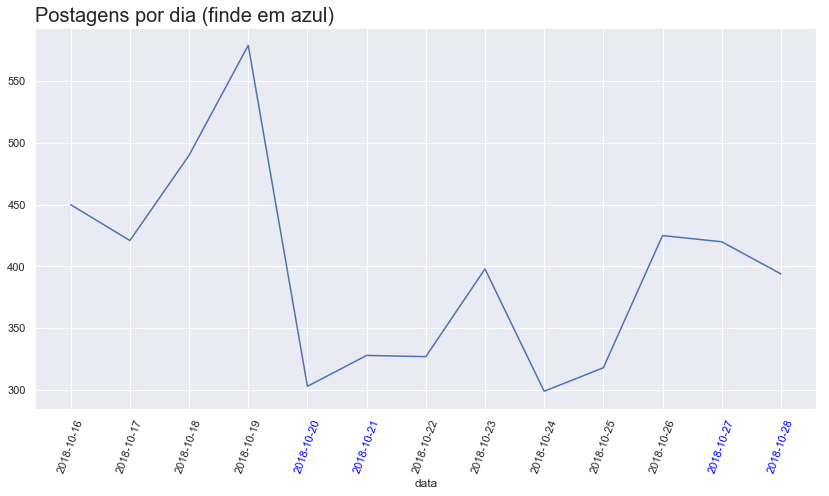

In [12]:
import dateutil.parser
df_freq_por_dia =  df_freq.groupby(df_freq.data.dt.date).size()

ax = df_freq_por_dia.plot.line()
ax.set_xticks(df_freq.data.dt.date.unique())
ax.set_xticklabels(df_freq.data.dt.date.unique())

[label.set_color('blue') for label in ax.get_xticklabels() if dtparse(label.get_text()).weekday() in [5,6]]
ax.set_title("Postagens por dia (finde em azul)", loc='left')
ax.tick_params(axis='x', labelrotation=70)

Pelo visto não há relação entre o número de posts e o fim de semana. Parece haver alguma redução, mas nada significativo.

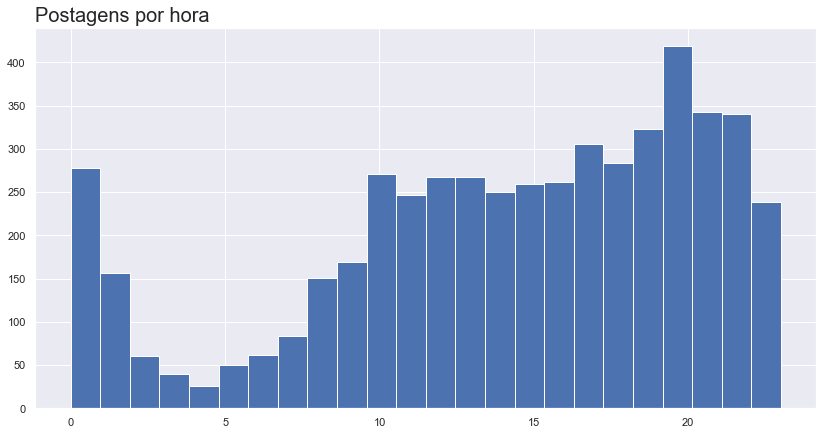

In [13]:
plt.hist(df_freq.data.dt.hour, bins=24);
plt.gca().set_title('Postagens por hora', loc='left');

O esperado é ter bem menos mensagens de madrugada. Caso contrário são robôs, gente paga, ou bolsonaristas com TOC e afetamina. Não acho que haja muita diferença entre as opções possíveis.

In [14]:
percentagem_midia = (tipos.loc[['midia', 'youtube']].sum() / 
                     tipos.loc[['midia', 'youtube', 'texto']].sum())
    

printBig('{:.2%} são vídeo, áudio ou imagens'.format(percentagem_midia))

Percentual das mensagens que são vídeo ou imagens. Multimídia é caro de produzir. Isto é uma boa indicação que há uma infraestrutura por trás gerando conteúdo para estes fóruns.

In [15]:
printBig('{:d} pessoas diferentes postaram'.format(df.tel.unique().size))

Um grupo de WhatsApp  pode ter no máximo **256 pessoas**. Um número grande pessoas postando indica várias pessoas reais participando e que o grupo está cumprindo seu papel de divulgação, pois há pessoas reais interagindo. Note que nem todas as pessoas que postaram estavam presentes no grupo ao mesmo tempo. As pessoas vão entrando e saindo. 

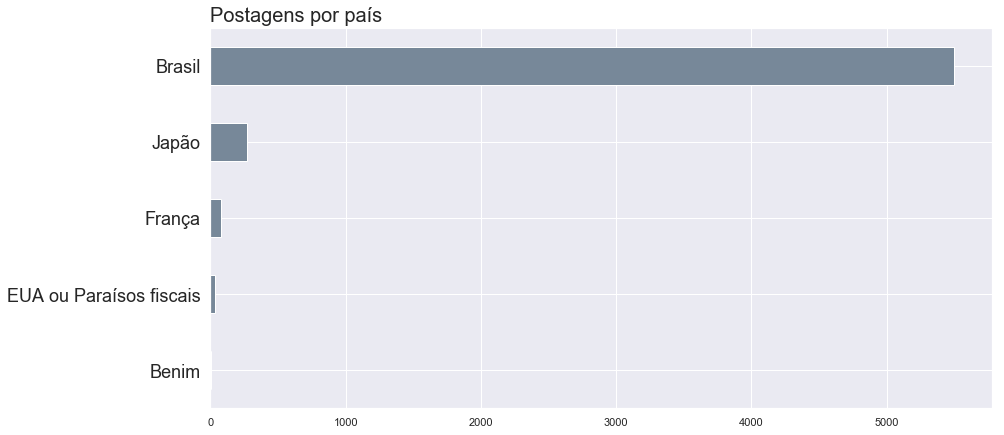

In [16]:
#tabela ddi editada na mão, códigos originais no outro arquivo
ddi = pd.read_table('ddi-paises-sem-duplicadas.tab', names=['ddi', 'pais_nome', 'continente'])

# efeito colateral: remove os participantes que estão nos contatos de quem gerou o arquivo
# vai remover pelo menos quem gerou o arquivo
df_pais = df.merge(ddi, left_on='pais', right_on='ddi')


df_pais.groupby('pais_nome').size().sort_values().plot.barh(color='lightslategray')
plt.ylabel("")
plt.gca().set_title("Postagens por país", loc='left')
plt.yticks(fontsize=18);

É estranho ter gente fora do Brasil. Mas brasileiro está espalhado no mundo todo. Algumas das reportagens afirmam que a campanha se vale de números no exterior para não ficarem ao alcance das leis brasileiras

### Os obsessivos

Um pequeno número de pessoas posta muito mais que os demais. Estes são obsessivos

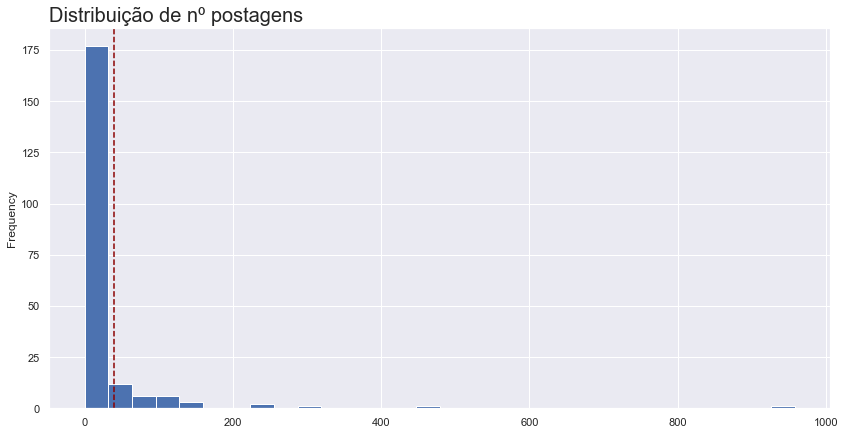

In [17]:
num_posts = df_freq.groupby('fone').size().sort_values(ascending=False)
iiq = num_posts.quantile([.25, .5, .75]).values
outliers_limit = iiq[2] + (iiq[2] - iiq[0]) * 1.5 
num_bins=30
ax = num_posts.plot.hist(bins=num_bins)
ax.set_title('Distribuição de nº postagens', loc='left')
ax.axvline(outliers_limit, linestyle='--', label="Obssessivos", color='darkred');

Em uma distribuição normal, quem está à direita da linha tracejada, normalmente seria considerado um outlier, isto é, um _"ponto fora da curva"_ por absurdamenteo mais que a média. Vou considerar como obsessivo apenas quem postou ainda bem mais do que os outros.

In [18]:
hist, _ = np.histogram(num_posts.values, bins=num_bins)
apos_buraco = False;
for i, v in enumerate(hist):
    if not apos_buraco and v == 0:
        apos_buraco = True;
    elif apos_buraco and v > 0:
        break
obsessivos_fones = num_posts[num_posts >= (num_posts.max()/num_bins * i)].index

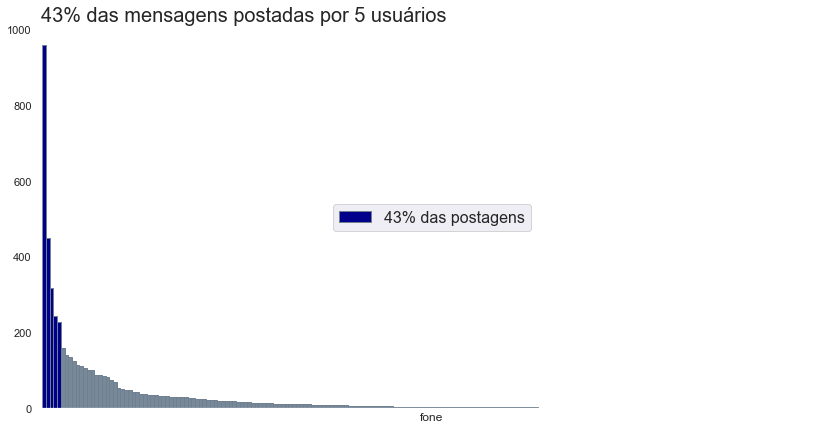

In [19]:
obsessivos_mask = num_posts.index.isin(obsessivos_fones)
obsessivos = num_posts[obsessivos_mask]
cores = np.where(obsessivos_mask, 'darkblue', 'lightslategrey')
                 
ax = num_posts.plot.bar(color=cores, width=1, edgecolor='slategrey')
ax.tick_params(labelbottom=False)
ax.grid(False)
ax.set_facecolor('white')
percentual_msgs = obsessivos.sum()/num_posts.sum()
ax.set_title("{:.0%} das mensagens postadas por {:d} usuários".format(percentual_msgs, obsessivos.size), 
             loc='left')
ax.legend(["{:.0%} das postagens".format(percentual_msgs)], prop={'size': 16}, loc="center");

Cada coluna é um número de telefone e a altura representa quantas postagens cada um fez.

Há um usuário que postou muito mais do que os outros. Foi mais que o dobro do segundo colocado. 

#### Números que mais postam:

In [20]:
obsessivos

fone
+55 94 9147#0050     958
+55 14 99885#0209    449
+55 45 9851#0526     316
+81 90-1210#0254     242
+55 19 99572#0044    227
dtype: int64

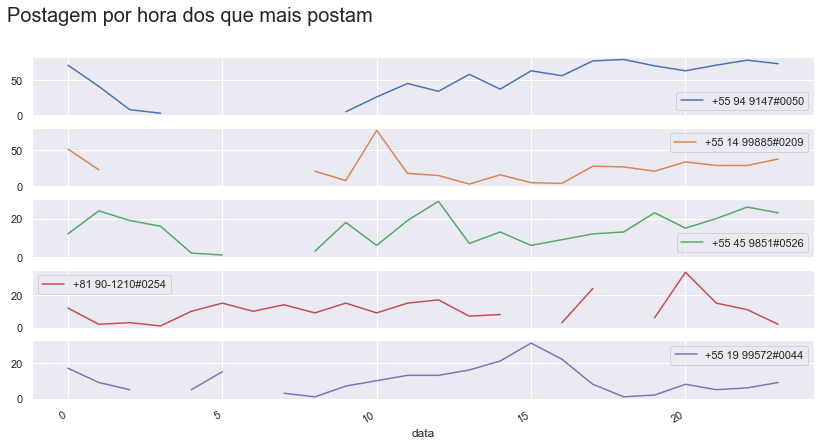

In [21]:
df_freq[df_freq.fone.isin(obsessivos.index)]\
    .groupby(["fone", df_freq.data.dt.hour]).size()\
    .unstack(0)\
    .reindex(obsessivos.index, axis=1)\
    .plot.line(subplots=True);
plt.gcf().suptitle('Postagem por hora dos que mais postam', horizontalalignment="left", x=.1, fontsize=20);

Os buracos indicam que as pessoas realmente dormem. O mais interessante é que o cara que é do Japão (código 81) dorme em outro horário e posta na nossa madrugada (mas teve insônia um dia). 

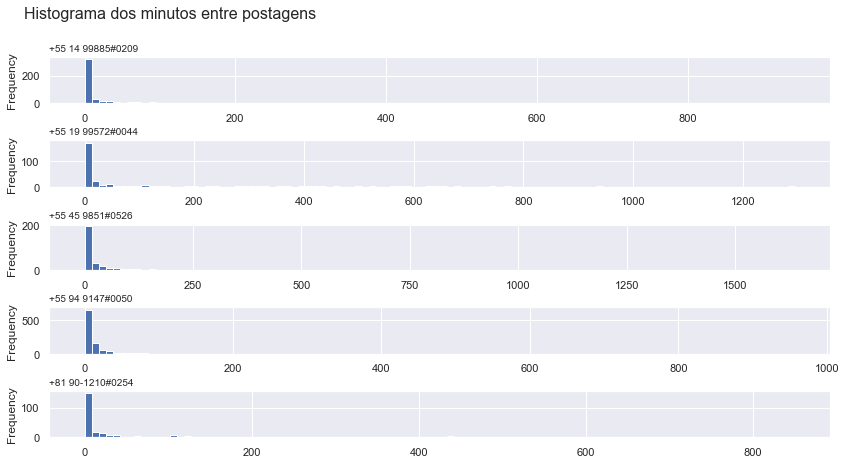

In [22]:
# Analisando o intervalo entre uma mensagem e outra dos que mais postam
ax=None
from matplotlib.text import Text

#um plot para cada obsessivo
fig, axis = plt.subplots(nrows=obsessivos.size, ncols=1, sharex=False, sharey=False)
fig.subplots_adjust(hspace=.8)
pos = 0
for fone, obsessivo in df[df.fone.isin(obsessivos.index)].groupby('fone'):
    if (obsessivo.empty):
        continue
    ax = axis[pos]
    pos += 1
    #diferença de tempo em segundos
    (obsessivo.data - obsessivo.data.shift(1)).dt.total_seconds().div(60).plot.hist(ax=ax, bins=100)
    ax.set_title(fone, {'fontsize': 10}, loc='left')
fig.suptitle('Histograma dos minutos entre postagens', horizontalalignment="left", x=0.1, fontsize=16);

O dado acima é enrolado de interpretar mas deu uma boa ideia. Ao exportar o arquivo, o WhatsApp só mostra a hora em cada postagem foi feita até o minuto. Mensagens enviadas no mesmo minuto tem grande chance de serem mensagens encaminhadas. O tamanho do eixo X indica que há pelo menos uma mensagem que foi postada naquele intervalo de tempo. Um limite maior no eixo X mostra maior chance de ser uma pessoa real.

### Como os administrados postam?

Vamos ver quantos dos que mais postaram no grupo estão entre os moderadores.

In [23]:
num_moderaores_obsessivos = moderadores[moderadores.fone.isin(obsessivos.index)].fone.count()

printBig(f'Existem {num_moderaores_obsessivos} moderadores entre os que mais postam!')


Nenhum dos administradores está entre os que mais postaram! Esta é uma tática para manter o grupo caso as contas de muitas postagens sejam bloqueadas. Na primeira vez que medi nenhum dos administradores estavam entre os que mais postavam, na segunda, após a eleição e o bloqueio do grupo, um deles passou a postar bastante.

In [24]:
rank_moderadores = moderadores.merge(pd.DataFrame(num_posts.rank(ascending=False, method='min')),
                                     right_index=True, left_on="fone")
rank_moderadores.columns= ['fone', 'nº moderações', 'Ranking de postagem']
rank_moderadores
      

,fone,nº moderações,Ranking de postagem
20,+55 11 98194#0151,1,7.0
24,+55 11 98597#0001,6,22.0
26,+55 11 98900#0066,11,29.0


No dia 15 de outubro, que foi o dia em que entrei no grupo, neste dia os administradores postavam à beça, mas subtamente pararam. Por que?

### Postagem por estado

In [25]:
from ddd import df_ddd

df['estado'] = df.merge(df_ddd, left_on='uf', right_on='Prefixo')['Estado']


uf = df.groupby(['estado']).size().sort_values(ascending=False).reset_index(name="Posts por estado")
printBig('{:d} dos 26 estados postaram'.format(uf.index.size))


uf.set_index('estado', inplace=True)
uf

,Posts por estado
estado,
São Paulo,1628
Pará,1018
Paraná,484
Minas Gerais,424
Ceará,278
Rio de Janeiro,257
Mato Grosso,245
Distrito Federal,205
Alagoas,171


### Telefones que divulgam mais links para assinar outros grupos

In [26]:
num_convites = pd.DataFrame(df[df.tipo == 'convite'].groupby('fone').size(), columns=['num_convites'])
num_convites = num_convites[num_convites.num_convites > 0]
num_convites['moderador'] = num_convites.index.isin(moderadores.fone)
num_convites['obsessivos'] = num_convites.index.isin(obsessivos.index)
num_convites

,num_convites,moderador,obsessivos
fone,,,
+55 11 98597#0001,1,True,False
+55 27 99923#0228,1,False,False
+55 31 9559#0057,11,False,False
+55 43 9686#0282,3,False,False
+55 62 9646#0087,1,False,False
+55 65 9214#0065,1,False,False
+55 67 9351#0198,6,False,False
+55 83 8134#0439,1,False,False
+55 83 9973#0010,35,False,False


Os usuários que enviam convites não são os moderadores nem os usuários que mais postam. Estranho. 

No caso específico deste grupo apenas os administradores podem criar links para que entrem nele. Será que nos demais também é assim?

Vamos ver para quantos grupos diferentes foram enviados convites para entrar:

In [27]:
num_grupos = df.loc[(df.tipo == 'convite'), ['fone', 'texto']].texto.nunique()

printBig(f'Foram enviados {num_convites.num_convites.sum()} convites para assinar {num_grupos} grupos diferentes')

## Nuvem de palavras

Apenas porque sempre há de se fazer uma nuvem de palavras. Nunca é muito informativo. Mas bem que eu esperava mais "comunista".

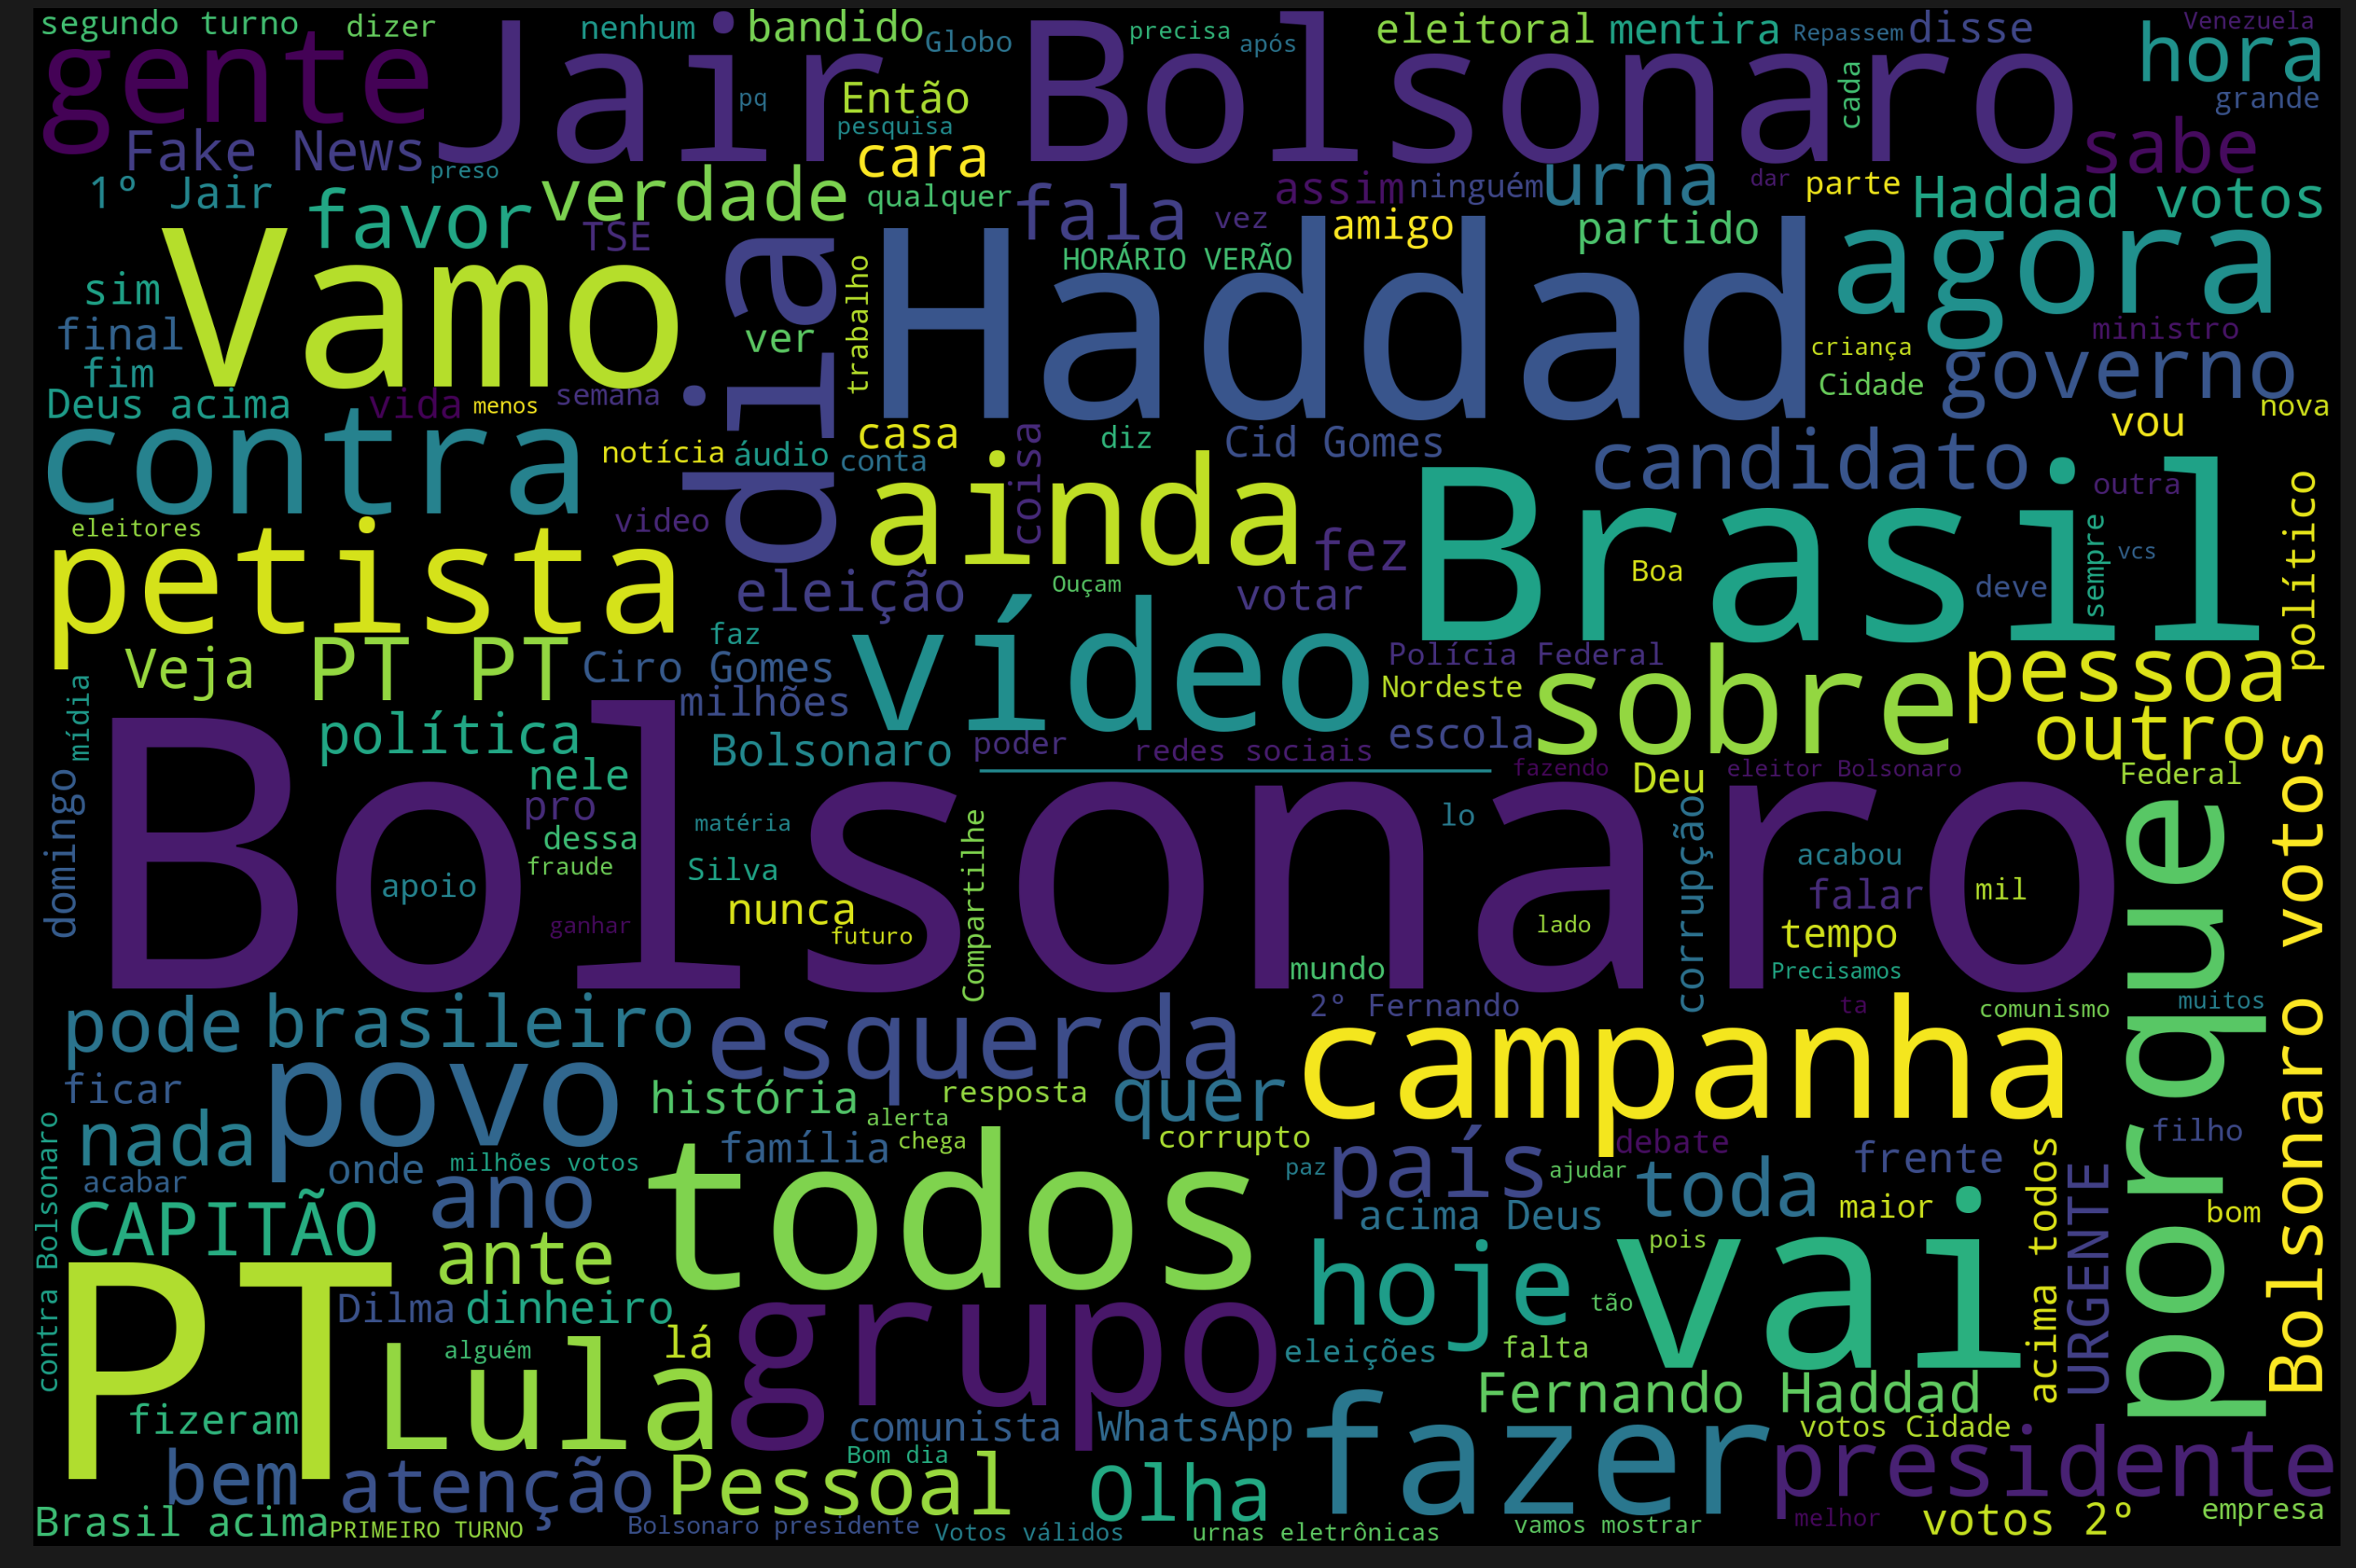

In [62]:
from wordcloud import WordCloud

STOPWORDS = open('stopwords-pt.txt', encoding='utf-8').read().splitlines()

text = ' '.join(df[(df.tipo=='texto') & (~df.texto.str.contains(' moto '))].texto.values)

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate((text))

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
